In [5]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import wandb
import utils
from torch.utils.data import DataLoader
import tqdm as tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from utils import load_csv, drop_cols, remove_strings, groupedAvg, subsample, normalize
from create_dataset import AnimalDataset, AnimalDatasetEmbedding, UnpairedDataset
from generators import BasicGenerator, SkipConGenerator, OneHotGenerator, ResNetGenerator
from discriminators import PatchDiscriminator, SampleDiscriminator
import os
import glob

In [6]:
# Receptive field of discriminator

# def f(output_size, ksize, stride):
#     return (output_size - 1) * stride + ksize

# last_layer = f(output_size=1, ksize=4, stride=2)
# print(last_layer)
# # Receptive field: 3
# fourth_layer = f(output_size=last_layer, ksize=3, stride=2)
# print(fourth_layer)
# # Receptive field: 7
# third_layer = f(output_size=fourth_layer, ksize=4, stride=3)
# print(third_layer)
# # Receptive field: 15
# second_layer = f(output_size=third_layer, ksize=4, stride=3)
# print(second_layer)
# # Receptive field: 31
# first_layer = f(output_size=second_layer, ksize=4, stride=3)
# # Receptive field: 63
# print(first_layer)

In [7]:
# config
UNPAIRED = True 
PHASES = [1]
SKIPCONNECTIONS = False

UNET = True
RESNET = False
BLOCKS = 6

PATCH = True

# LR scheduler
MultiStepLR = False
GAMMA = 0.1

ReduceLROnPlateau = False
FACTOR = 0.001
PATIENCE = 2

PolinomialLR = True
power = 1
LR_DECAY_AFTER_EPOCH = 50



# DISCRIMINATOR = MultiChannelDiscriminator
# GENERATOR = BasicGenerator   # BasicGenerator, SkipConGenerator

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 1
LEARNING_RATE = 0.0002 #1e-2
NUM_WORKERS = 16
NUM_EPOCHS = 100

SIG_A = "AoP"           # Drucksignal Hauptschlagader = Aortendruck
SIG_B = "VADcurrent"    # VAD Strom [A] – Pumpemstrom in Ampere
SIG_C = "VadQ"          # Fluss durch VAD (VAD = Ventrikular assistance device = Pumpe) = Pumpenfluss
SIG_D = "LVP"           # Ventrikeldruck links = Drucksignal der linken Herzkammer
TARGET = "LVtot_kalibriert"  # RVtot_kalibriert existiert auch
source_signals = [SIG_D]
CHANNELS = len(source_signals)
WINDOW = 256

# Use adversarial loss
LAMBDA_DISC = 0.05
GAN_LOSS = True   # adversarial loss
LAMBDA_GAN = 1.0
# Use cycle consistency loss
CYCLE = True
LAMBDA_CYCLE = 1.0
# Use supervised loss
SUPERVISED = False 
LAMBDA_SUPERVISED = 1.0
# Use Identity loss
IDENTITY = False
LAMBDA_IDENTITY = 1.0

### Load all data and preprocess

Subsamplen, normalisieren pro Datei

In [8]:
path = "/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/csv_export_files_alle_Daten/csv_export_files" 
csv_files = glob.glob(os.path.join(path, "*.csv"))
  
df = pd.DataFrame()
scaler = StandardScaler() 
# loop over the list of csv files
for f in csv_files:
      
    # read the csv file
    df_temp = pd.read_csv(f, sep=";")
    df_temp = utils.drop_cols(df_temp)
    df_temp = df_temp.dropna()
    df_temp = utils.remove_strings(df_temp)
    df_temp = utils.subsample(df_temp, 10)
    df_temp = utils.normalize(df_temp, scaler, phase1 = True)  
      
    # print the content
    df = pd.concat([df, df_temp], axis=0)
    

print(df.shape)

(6022044, 14)


phase 1 preload
phase 2 und 3 sind afterload
phase 4 ist speedramp
phase 10:
        contractility = 1 -> nichts
        contractility = 3 -> Dubotamin 
        contractility = 4 -> ischaemie

In [9]:
df = df.reset_index(drop=True)

for index, row in df.iterrows():
    if row['Phasenzuordnung'] == 1:
        df.at[index, 'intervention'] = 0
    elif row['intervention'] == 10:
        if row['contractility'] == 1.0:
            df.at[index, 'intervention'] = 0      # contractility = 1.0 - could be ignored? - phase 0?
        if row['contractility'] == 3.0:
            df.at[index, 'intervention'] = 5      # contractility = 3.0                                        
        if row['contractility'] == 4.0:
            df.at[index, 'intervention'] = 6    # contractility = 4.0

#get unique intervention
print(df['intervention'].unique())

[0. 1. 3. 6. 2. 4. 5.]


### Select part of data to use in experiment

In [10]:
# select Phasenzuordnung = 1 and 3
df = df.loc[df['Phasenzuordnung'].isin(PHASES)]
print('Size of the dataset after selecting Phasenzuordnung 1',df.shape)

print('Size of the dataset with data from phase 1',df.shape)
print('Size of Phase 1: ', df.loc[df['Phasenzuordnung'] == 1].shape)
print('Size of Phase 2: ', df.loc[df['Phasenzuordnung'] == 2].shape)
print('Size of Phase 3: ', df.loc[df['Phasenzuordnung'] == 3].shape)
print('Size of Phase 4: ', df.loc[df['Phasenzuordnung'] == 4].shape)
print('SIze of Phase 5: ', df.loc[df['Phasenzuordnung'] == 5].shape)

Size of the dataset after selecting Phasenzuordnung 1 (751120, 14)
Size of the dataset with data from phase 1 (751120, 14)
Size of Phase 1:  (751120, 14)
Size of Phase 2:  (0, 14)
Size of Phase 3:  (0, 14)
Size of Phase 4:  (0, 14)
SIze of Phase 5:  (0, 14)


In [11]:
df['intervention'].unique()

array([0.])

### Drop animals with less than 10 data points
We drop animals from the dataframe, if they have less than 10 data points. Initially, we have 56 animals and after dropping those with close to no data points, we are left with 25 animals

In [12]:
print(len(df['animal'].unique()))
# remove animals with less than 10 data points
df = df.groupby('animal').filter(lambda x: len(x) > 10)
print('Number of animals after removing those with less than 10 data points: ', len(df['animal'].unique()))

# get all differnent animals
animals = df['animal'].unique()
print(animals)

25
Number of animals after removing those with less than 10 data points:  25
[  8  12  13 108   7  14  11   2  16  10 105 111  17  19   3  15   5  20
 113   4 102   1   9 107 101]


### Split data into train and test split

The 5 test animals represent 20.20924% of the whole data. If we don't use all phases, this number might be different

In [13]:
# select animals 3,4,8,11,17 as test animals
test_animals = [3,4,8,11,17] 

print('\nTest animal(s):', test_animals)

all_animals = df['animal'].unique()
# remove test animals from train animals
train_animals =  [x for x in all_animals if x not in test_animals]

# test data
df_test = df[df['animal'].isin(test_animals)]

# change the length of the test data to a multiple of the Window size
df_test = df_test.iloc[:len(df_test) - (len(df_test) % WINDOW)]

# train dataframe with only animals from train_animals
df_train = df[df['animal'].isin(train_animals)]
print('\nDifferent animal IDs after removing those that are in the test dataset: ',len(df_train['animal'].unique()))


print('\nTrain data shape:', df_train.shape)
print('\nTest data shape:', df_test.shape)

# lengt of df_train
print('\nThe test dataset is {} percent of the whole data: '.format((len(df_test)/(len(df_train) + len(df_test))) * 100))


Test animal(s): [3, 4, 8, 11, 17]

Different animal IDs after removing those that are in the test dataset:  20

Train data shape: (591930, 14)

Test data shape: (158976, 14)

The test dataset is 21.171225160006713 percent of the whole data: 


In [14]:
from sklearn.model_selection import train_test_split

#SEEDS 
seed_1 = 1
seed_2 = 2
seed_3 = 3

#split train dataset into train and validation split
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=seed_2, shuffle=False)

print(df_train.shape)
print(df_val.shape)

(473544, 14)
(118386, 14)


#### Initialize Generator and Discriminator

We also initialize the 2 optimizers, the 2 Learning rate schedulers, the losses


In [15]:
# # Try out InstanceNorm1d instead of BatchNorm1d

# def residual_block(in_channels, out_channels):
#     return nn.Sequential(
#         nn.Conv1d(in_channels, out_channels, kernel_size=1, stride = 1, padding=0),
#         nn.BatchNorm1d(out_channels),
#         nn.ReLU(inplace=True),
#         nn.Conv1d(out_channels, out_channels, kernel_size = 1, stride = 1, padding=0),
#         nn.BatchNorm1d(out_channels),
#     )

# def single_conv_pad(in_channels, out_channels):
#     return nn.Sequential(
#         nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1, padding_mode='zeros'),
#         nn.BatchNorm1d(out_channels),
#         nn.LeakyReLU(inplace=True),
#         nn.Dropout1d(p=0.1, inplace=False),
#     )

# class ResNetGenerator(nn.Module):
#     def __init__(self, INPUTCHANNELS, OUTPUTCHANNELS, blocks=6):
#         super(ResNetGenerator, self).__init__()
#         '''
#         A Basic Unet Generator without skip connections
#         '''
#         self.blocks = blocks

#         self.maxpool = nn.MaxPool1d((2))  

#         self.down_conv1 = single_conv_pad(INPUTCHANNELS, 64) 
#         self.down_conv2 = single_conv_pad(64, 128)
#         self.down_conv3 = single_conv_pad(128, 256)

#         self.residual1 = residual_block(256, 256)
#         self.residual2 = residual_block(256, 256)
#         self.residual3 = residual_block(256, 256)
#         self.residual4 = residual_block(256, 256)
#         self.residual5 = residual_block(256, 256)
#         self.residual6 = residual_block(256, 256)
#         self.residual7 = residual_block(256, 256)
#         self.residual8 = residual_block(256, 256)
#         self.residual9 = residual_block(256, 256)

#         self.up_trans1 = nn.ConvTranspose1d(256, 128, kernel_size=(2), stride=2, padding=0)
#         self.up_conv1 = single_conv_pad(128, 128)
#         self.up_trans2 = nn.ConvTranspose1d(128, 64, kernel_size=(2), stride=2, padding=0)
#         self.up_conv2 = single_conv_pad(64, 64)

#         self.out = nn.Conv1d(64, OUTPUTCHANNELS, kernel_size=1) # kernel_size must be == 1

#     def forward(self, input):
#         # [Batch size, Channels in, Height, Width]
#         x1 = self.down_conv1(input) 
#         x2 = self.maxpool(x1) 
#         x3 = self.down_conv2(x2)
#         x4 = self.maxpool(x3) 
#         x5 = self.down_conv3(x4) 

#         # residual blocks
#         x5 = x5 + self.residual1(x5)
#         x5 = x5 + self.residual2(x5)
#         x5 = x5 + self.residual3(x5)
#         if self.blocks > 3:
#             x5 = x5 + self.residual4(x5)
#             x5 = x5 + self.residual5(x5)
#             x5 = x5 + self.residual6(x5)           
#         if self.blocks > 6:
#             x5 = x5 + self.residual7(x5)
#             x5 = x5 + self.residual8(x5)
#             x5 = x5 + self.residual9(x5)  # x5.shape =  torch.Size([1, 256, 64])

#         # # decoder
#         x = self.up_trans1(x5)
#         x = self.up_conv1(x)
#         x = self.up_trans2(x)
#         x = self.up_conv2(x)
#         x = self.out(x)

#         return x

In [16]:
# Generator
if UNET:
    if not SKIPCONNECTIONS:
        gen_target = BasicGenerator(INPUTCHANNELS = CHANNELS, OUTPUTCHANNELS = 1).to(DEVICE)
        gen_source = BasicGenerator(INPUTCHANNELS = 1, OUTPUTCHANNELS = CHANNELS).to(DEVICE)

    if SKIPCONNECTIONS:
        gen_target = SkipConGenerator(INPUTCHANNELS = CHANNELS, OUTPUTCHANNELS = 1).to(DEVICE)
        gen_source = SkipConGenerator(INPUTCHANNELS = 1, OUTPUTCHANNELS = CHANNELS).to(DEVICE)
if RESNET:
    gen_target = ResNetGenerator(INPUTCHANNELS = CHANNELS, OUTPUTCHANNELS = 1, blocks=BLOCKS).to(DEVICE)
    gen_source = ResNetGenerator(INPUTCHANNELS = 1, OUTPUTCHANNELS = CHANNELS, blocks=BLOCKS).to(DEVICE)


# gen_target receives source signals and generates a target signal
# gen_source receives a target signal and generates source signals

# Discriminator
if PATCH:
    disc_target = PatchDiscriminator(CHANNELS = 1).to(DEVICE)
    disc_source = PatchDiscriminator(CHANNELS = CHANNELS).to(DEVICE)

if not PATCH:
    disc_target = SampleDiscriminator(CHANNELS = 1).to(DEVICE)
    disc_source = SampleDiscriminator(CHANNELS = CHANNELS).to(DEVICE)

# Optimizers
opt_disc = torch.optim.AdamW(                                         
    list(disc_source.parameters()) + list(disc_target.parameters()), 
    lr=LEARNING_RATE, 
)
opt_gen = torch.optim.AdamW(
    list(gen_source.parameters()) + list(gen_target.parameters()),
    lr=LEARNING_RATE,
)

# Schedulers
if ReduceLROnPlateau:
    gen_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer = opt_gen,
                                                            factor=FACTOR, patience=PATIENCE, threshold=1e-4,
                                                            min_lr=1e-6,
                                                        )
    disc_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer = opt_disc,
                                                                factor=FACTOR, patience=PATIENCE, threshold=1e-4,
                                                                min_lr=1e-6,
                                                        )
if MultiStepLR:
    gen_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer = opt_gen, milestones=[1], gamma=GAMMA)
                                                        
    disc_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer = opt_disc, milestones=[1], gamma=GAMMA)

if PolinomialLR:
    gen_scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer = opt_gen,
                                                      total_iters = NUM_EPOCHS-LR_DECAY_AFTER_EPOCH, 
                                                      power = power,
                                                    )
    disc_scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer = opt_disc,
                                                       total_iters = NUM_EPOCHS-LR_DECAY_AFTER_EPOCH, 
                                                       power = power,
                                                    )

# losses
l1 = nn.L1Loss() 
mse = nn.MSELoss()

### Load all checkpoints

In [17]:
# CHECKPOINT_GEN_target = 'Checkpoints/Basic_Generator/Epo200_Dec100/gen_target_BG_200_LRD100.pth.tar'
# CHECKPOINT_GEN_source = 'Checkpoints/Basic_Generator/Epo200_Dec100/gen_source_BG_200_LRD100.pth.tar'

# utils.load_checkpoint(CHECKPOINT_GEN_target, gen_target, opt_gen, LEARNING_RATE)
# utils.load_checkpoint(CHECKPOINT_GEN_source, gen_source, opt_gen, LEARNING_RATE)

#### Create the dataset and DataLoader

In [18]:
if UNPAIRED:
    # create datasets without information of the phases and interventions (embedding information)
    train_dataset = UnpairedDataset(df_train, source_signals, target_name = TARGET, test = False, window_length = WINDOW)
    test_dataset = AnimalDataset(df_test, source_signals, target_name = TARGET, test = True, window_length = WINDOW)
    validation_dataset = UnpairedDataset(df_val, source_signals, target_name = TARGET, test = False, window_length = WINDOW)
    

if not UNPAIRED:
    # create datasets without the embedding information
    train_dataset = AnimalDataset(df_train, source_signals, target_name = TARGET, test = False, window_length = WINDOW)
    test_dataset = AnimalDataset(df_test, source_signals, target_name = TARGET, test = True, window_length = WINDOW)
    validation_dataset = AnimalDataset(df_val, source_signals, target_name = TARGET, test = False, window_length = WINDOW)

# DataLoader
loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True,)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True,)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True,)


#### Initialize weights and bias

In [19]:
#start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="Cycle_GAN",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": LEARNING_RATE,
    "epochs": NUM_EPOCHS,
    }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: johann4dl (johannanton). Use `wandb login --relogin` to force relogin


In [20]:
def discriminator_loss(disc, reals, fakes):
    # calculate how close reals are to being classified as real
    real_loss = mse(disc(reals), torch.ones_like(disc(reals)))
    # calculate how close fakes are to being classified as fake
    fake_loss = mse(disc(fakes), torch.zeros_like(disc(fakes)))
    # return the average of real and fake loss
    return (real_loss + fake_loss)


# @torch.cuda.amp.autocast()
def get_disc_loss_no_embedding(sig_A, sig_B,  
                    disc_A, disc_B, gen_A, gen_B, fake_A, fake_B
                    ):
    """
    Return the loss of the discriminator given inputs.
    """
    # discriminator loss
    disc_B_loss = discriminator_loss(disc_B, sig_B, fake_B) * LAMBDA_DISC
    disc_A_loss = discriminator_loss(disc_A, sig_A, fake_A) * LAMBDA_DISC
    disc_loss = (disc_A_loss + disc_B_loss)  

    return disc_loss, disc_A_loss, disc_B_loss

# @torch.cuda.amp.autocast()
def calc_gen_loss_no_embedding(source, target, 
                  gen_source, gen_target, disc_source, disc_target, fake_target, fake_source
                  ):
    loss = 0

    if CYCLE:
        rec_target = gen_target(fake_source)
        rec_source = gen_source(fake_target)
        cycle_target_loss = l1(target, rec_target)  # l1 loss in cycle GAN paper
        cycle_source_loss = l1(source, rec_source)  

        loss += cycle_target_loss * LAMBDA_CYCLE + cycle_source_loss * LAMBDA_CYCLE
    else:
        cycle_target_loss = torch.tensor(0)
        cycle_source_loss = torch.tensor(0)

    if GAN_LOSS:
        g_source_loss = mse(disc_source(fake_source), torch.ones_like(disc_source(fake_source))) # optimally, disc outputs 1 for a fake signal
        g_target_loss = mse(disc_target(fake_target), torch.ones_like(disc_target(fake_target))) 

        loss += g_source_loss * LAMBDA_GAN + g_target_loss * LAMBDA_GAN
    else:
        g_source_loss = torch.tensor(0)
        g_target_loss = torch.tensor(0)

    if SUPERVISED:
        sup_source_loss = mse(source, fake_source)
        sup_target_loss = mse(target, fake_target)

        loss += sup_source_loss * LAMBDA_SUPERVISED + sup_target_loss * LAMBDA_SUPERVISED
    else:
        sup_source_loss = torch.tensor(0)
        sup_target_loss = torch.tensor(0)

    if IDENTITY:
        id_target_loss = l1(target, gen_target(target))
        id_source_loss = l1(source, gen_source(source))

        loss += id_target_loss * LAMBDA_IDENTITY + id_source_loss * LAMBDA_IDENTITY
    else:
        id_target_loss = torch.tensor(0)
        id_source_loss = torch.tensor(0)

    return loss, g_source_loss, g_target_loss, cycle_target_loss, cycle_source_loss, id_target_loss, id_source_loss, sup_source_loss, sup_target_loss

In [21]:
losses = {
    'L1 loss source' : [],
    'L1 loss target' : [],
}

In [22]:
# training loop
from tqdm.auto import tqdm

for epoch in tqdm(range(NUM_EPOCHS)):

    for source, target in loader:
        # convert to float16
        source = source.float() # neccessary to prevent error: "Input type (torch.cuda.DoubleTensor) 
        target = target.float() # and weight type (torch.cuda.HalfTensor) should be the same"
    
        # move to GPU
        source = source.to(DEVICE)
        target = target.to(DEVICE)

        #  ------------------------------- #
        #  ----- train discriminators ---- #
        #  ------------------------------- #
        with torch.no_grad():
            fake_target = gen_target(source).detach()
            fake_source = gen_source(target).detach()

        d_loss, disc_source_loss, disc_target_loss = get_disc_loss_no_embedding(source, target,
                                                            disc_source, disc_target, gen_source, gen_target, 
                                                            fake_source, fake_target
                                                        )

        # update gradients of discriminator 
        opt_disc.zero_grad() 
        d_loss.backward()
        opt_disc.step()
        # d_scaler.scale(d_loss).backward()  
               

        # -------------------------------- #
        # ------- train generators ------- #
        # -------------------------------- # 

        out = calc_gen_loss_no_embedding(source, target,
                                gen_source, gen_target, disc_source, disc_target, 
                                fake_target, fake_source
                                )
        g_loss, g_source_loss, g_target_loss, cycle_target_loss, cycle_source_loss, id_target_loss, id_source_loss, sup_source_loss, sup_target_loss = out

        # update gradients of generator
        opt_gen.zero_grad()
        g_loss.backward()
        opt_gen.step()
        # g_scaler.scale(g_loss).backward()

    # Optimizer step
    # d_scaler.step(opt_disc)  
    # d_scaler.update()

    # g_scaler.step(opt_gen) 
    # g_scaler.update()

    wandb.log({'Train/Discriminator A loss': disc_source_loss.item(),
                'Train/Discriminator B loss': disc_target_loss.item(),
                'Train/Total Discriminator loss': d_loss.item(),
                'Train/Total Generator loss': g_loss.item(),
                'Train/Adversarial loss A': g_source_loss.item(),
                'Train/Adversarial loss B': g_target_loss.item(),
                'Train/Cycle consistency loss A': cycle_source_loss.item(),
                'Train/Cycle consistency loss B': cycle_target_loss.item(),
                'Train/Supervised loss A': sup_source_loss.item(),
                'Train/Supervised loss B': sup_target_loss.item(),
                'Learning rate': opt_gen.param_groups[0]["lr"],
                # 'Train/Identity loss A': id_A_loss.item(),
                # 'Train/Identity loss B': id_B_loss.item()
                })
        

    # ------------------------ #
    # ------ Validation ------ #
    # ------------------------ #

    if (epoch+1) % 25 == 0:

        with torch.no_grad():
            # set models to evaluation mode
            disc_source.eval()  # set discriminator to evaluation mode
            disc_target.eval()  # turns off Dropouts Layers, BatchNorm Layers etc
            gen_target.eval()
            gen_source.eval()

            for source, target in validation_loader:
                # convert to float16
                source = source.float()
                target = target.float()

                # move to GPU
                source = source.to(DEVICE)
                target = target.to(DEVICE)

                fake_target = gen_target(source).detach() # already torch.no_grad()
                fake_source = gen_source(target).detach()
                

                # generate signals during validation
                #gen_signals(fake_target, fake_source, target, source)

                # calculate l1 loss of fake signals and real signals
                test_real_fake_lossTarget = l1(target, fake_target)   # l1(sig_B, fake_B)
                test_real_fake_lossSource = l1(source, fake_source)
                # add to dict losses
                losses['L1 loss source'].append(test_real_fake_lossSource.item())
                losses['L1 loss target'].append(test_real_fake_lossTarget.item())

                #  ------------------------------- #
                #  ----- test discriminators ----- #
                #  ------------------------------- #

                test_d_loss, test_disc_source_loss, test_disc_target_loss = get_disc_loss_no_embedding(source, target, 
                                                                    disc_source, disc_target, gen_source, gen_target, 
                                                                    fake_source, fake_target
                                                                )
                
                # -------------------------------- #
                # ------- test generators -------- #
                # -------------------------------- # 

                out = calc_gen_loss_no_embedding(source, target,
                                        gen_source, gen_target, disc_source, disc_target, 
                                        fake_target, fake_source
                                        )
                g_lossT, g_source_lossT, g_target_lossT, cycle_target_lossT, cycle_source_lossT, id_target_lossT, id_source_lossT, sup_source_lossT, sup_target_lossT = out
        
                # gen_signals(fake_target, fake_source, target, source)

            wandb.log({'Test/Generator loss': g_lossT.item(),
                        'Test/Discriminator loss': test_d_loss.item(),
                        'Test/L1 loss between real signal A and fake signals A': test_real_fake_lossSource.item(),
                        'Test/L1 loss between real signal B and fake signals B': test_real_fake_lossTarget.item(),
                        'Test/Discriminator A loss': test_disc_source_loss.item(),
                        'Test/Discriminator B loss': test_disc_target_loss.item(),
                        'Test/Adversarial or GAN loss A': g_source_lossT.item(),
                        'Test/Adversarial or GAN loss B': g_target_lossT.item(),
                        'Test/Cycle consistency loss A': cycle_source_lossT.item(),
                        'Test/Cycle consistency loss B': cycle_target_lossT.item(),
                        'Test/Supervised loss A': sup_source_lossT.item(),
                        'Test/Supervised loss B': sup_target_lossT.item(),
                        'Test/Epoch': epoch+1,
                })
            
            
    if ReduceLROnPlateau:  
        disc_scheduler.step(d_loss) #d_loss # test_d_loss
        gen_scheduler.step(g_loss)  # g_loss # g_lossT

    if MultiStepLR:
        disc_scheduler.step()
        gen_scheduler.step()

    # scheduler step if epoch > LR_DECAY_AFTER_EPOCH
    if PolinomialLR == True and (epoch+1) >= LR_DECAY_AFTER_EPOCH:
        disc_scheduler.step()
        gen_scheduler.step()


 67%|██████▋   | 67/100 [1:21:53<36:05, 65.63s/it]  

### Get losses of the training run

In [ ]:
source_losses = []
target_losses = []

for source, target, in validation_loader:                                  
    source = source.float()
    target = target.float()
    source = source.to(DEVICE)
    target = target.to(DEVICE)

    fake_target = gen_target(source)
    fake_source = gen_source(target)
    l1_source = l1(source, fake_source)
    l1_target = l1(target, fake_target)
    source_losses.append(l1_source.item())
    target_losses.append(l1_target.item())

print(f"Average L1 loss of source signals: {np.mean(source_losses)}")
print(f"Average L1 loss of target signals: {np.mean(target_losses)}")

#get stadard deviation of loses
print('Standard deviation of source losses', np.std(source_losses))
print('Standard deviation of target losses', np.std(target_losses))

# # get min and max of losses
# min_max_loss_source = np.(source_losses), np.max(source_losses)
# min_max_loss_target = np.min(target_losses), np.max(target_losses)
# print(f"Min and max loss of source signals: {min_max_loss_source}")
# print(f"Min and max loss of target signals: {min_max_loss_target}")

# # get median of losses
# median_loss_source = np.median(source_losses)
# median_loss_target = np.median(target_losses)
# print(f"Median loss of source signals: {median_loss_source}")
# print(f"Median loss of target signals: {median_loss_target}")

Average L1 loss of source signals: 5.110260310925935
Average L1 loss of target signals: 1.0659990257008254
Standard deviation of source losses 1.8434665249185411
Standard deviation of target losses 0.3360196177027053


### Generate signals with the trained generators

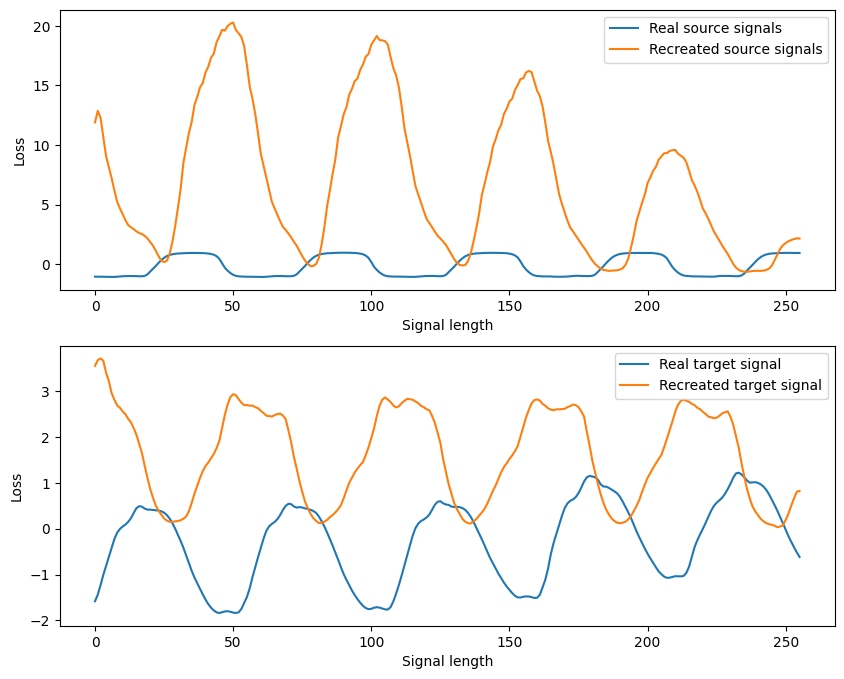

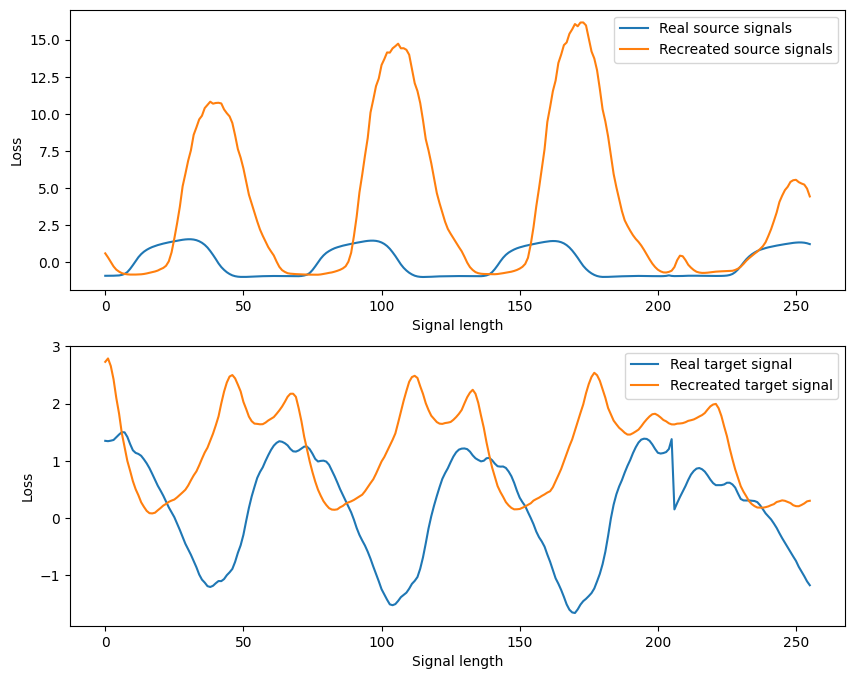

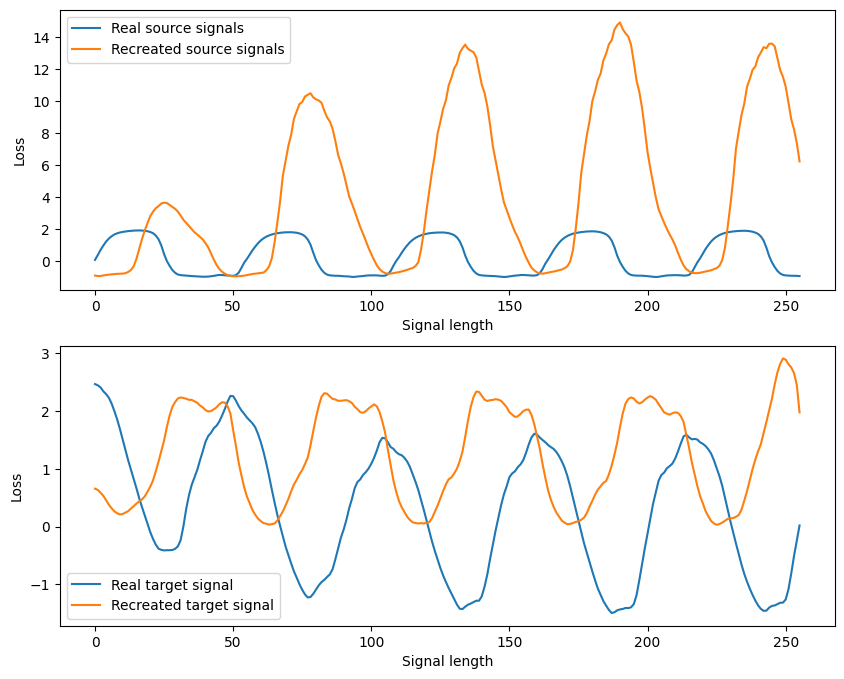

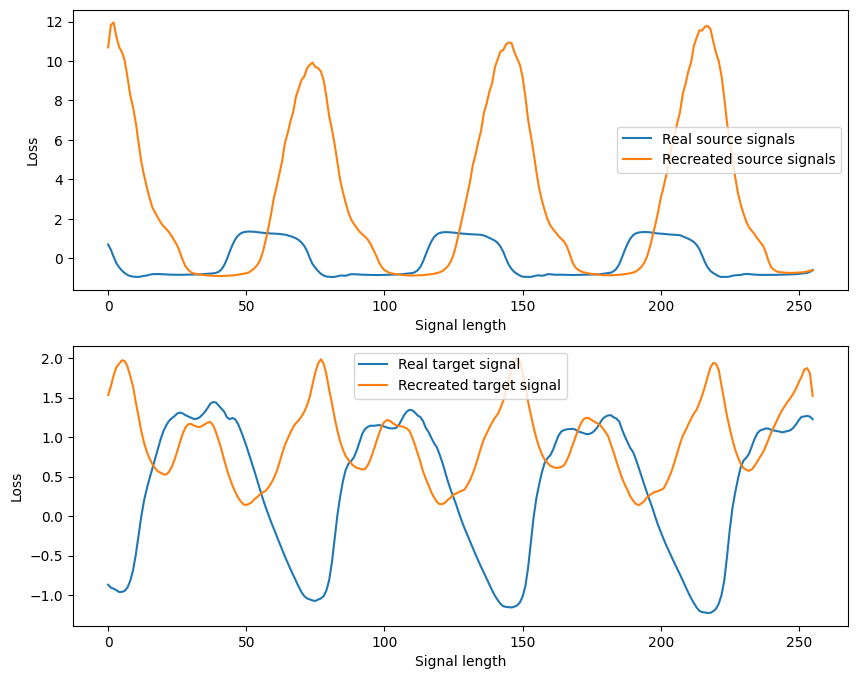

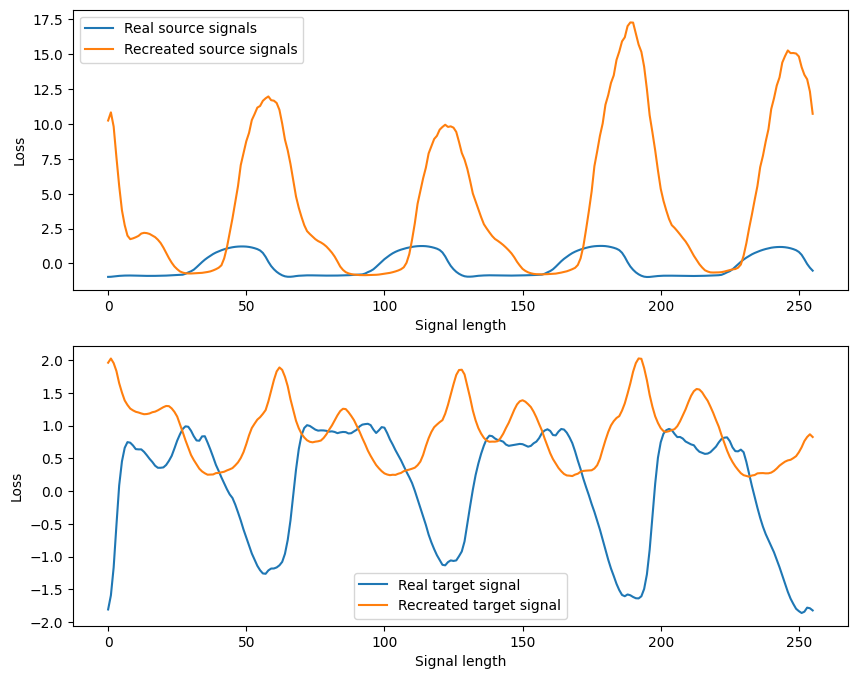

In [ ]:
#  Generate signals
idx = 0             

for source, target, in test_loader:
    if idx == 5:
        break                 
                    
    source = source.float()
    target = target.float()
    source = source.to(DEVICE)
    target = target.to(DEVICE)

    fake_target = gen_target(source)
    fake_source = gen_source(target)
    # fake_target = gen_source(gen_target(source))
    # fake_source = gen_target(gen_source(target))
                        
    fake_target = fake_target.reshape(-1)
    fake_source = fake_source.reshape(-1)
    source = source.reshape(-1)
    target = target.reshape(-1)

    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    ax[0].plot(source[:256].cpu().detach().numpy(), label= 'Real source signals')
    ax[0].plot(fake_source[:256].cpu().detach().numpy(), label= 'Recreated source signals')
    ax[0].set_xlabel('Signal length')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(target[:256].cpu().detach().numpy(), label= 'Real target signal')
    ax[1].plot(fake_target[:256].cpu().detach().numpy(), label= 'Recreated target signal')
    ax[1].set_xlabel('Signal length')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

    idx += 1       

In [ ]:
# Verify L1 loss of reconstructed and real signals, per phase and intervention
# array([ 0.,  1.,  3., 10.,  2.,  4.,  9.])
# df of phase 1
df_phase_1 = df_test.loc[df_test['Phasenzuordnung'].isin([1])]
df_phase_3 = df_test.loc[df_test['Phasenzuordnung'].isin([3])]

# 1.,  3., 10.,  2.,  4.
df_int_0 = df_test.loc[df_test['intervention'].isin([0])]
df_int_1 = df_test.loc[df_test['intervention'].isin([1])]
df_int_2 = df_test.loc[df_test['intervention'].isin([2])]
df_int_3 = df_test.loc[df_test['intervention'].isin([3])]
df_int_4 = df_test.loc[df_test['intervention'].isin([4])]
df_int_9 = df_test.loc[df_test['intervention'].isin([9])]
df_int_10 = df_test.loc[df_test['intervention'].isin([10])]

In [ ]:
verify_dataset = AnimalDataset(df_phase_1, source_signals, target_name = TARGET, test = True, window_length = WINDOW)
verify_loader = DataLoader(verify_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True,)

In [ ]:
source_losses = []
target_losses = []
for source, target, in verify_loader:                                  
    source = source.float()
    target = target.float()
    source = source.to(DEVICE)
    target = target.to(DEVICE)

    fake_target = gen_target(source)
    fake_source = gen_source(target)
    l1_source = l1(source, fake_source)
    l1_target = l1(target, fake_target)
    source_losses.append(l1_source.item())
    target_losses.append(l1_target.item())

print(f"Average L1 loss of source signals: {np.mean(source_losses)}")
print(f"Average L1 loss of target signals: {np.mean(target_losses)}")

# get min and max of losses
min_max_loss_source = np.min(source_losses), np.max(source_losses)
min_max_loss_target = np.min(target_losses), np.max(target_losses)
print(f"Min and max loss of source signals: {min_max_loss_source}")
print(f"Min and max loss of target signals: {min_max_loss_target}")

# get median of losses
median_loss_source = np.median(source_losses)
median_loss_target = np.median(target_losses)
print(f"Median loss of source signals: {median_loss_source}")
print(f"Median loss of target signals: {median_loss_target}")

In [ ]:
# save checkpoints

# utils.save_checkpoint(gen_source, opt_gen, path="phase_1_3_Basic_Gen.pth.tar")
# utils.save_checkpoint(gen_target, opt_gen, path="phase_1_3_Basic_Gen.pth.tar")
# utils.save_checkpoint(disc_source, opt_disc, path="phase_1_3_Basic_Gen.pth.tar")
# utils.save_checkpoint(disc_target, opt_disc, path="phase_1_3_Basic_Gen.pth.tar")